# Training a sentiment analysis classifier based on supervised machine learning algorithms

In [1]:
import string

import pandas as pd

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import TweetTokenizer

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import ConfusionMatrixDisplay, precision_score, recall_score, f1_score

In [2]:
pd.set_option('display.max_colwidth', None)

In [3]:
stop_words = set(stopwords.words('spanish'))

In [4]:
def tokenizer(text):
    tt = TweetTokenizer()
    return tt.tokenize(text)

### Loading labeled tweets

In [18]:
# Dataset loaded from: https://docs.google.com/spreadsheets/d/11_E2ngsEOyTQwbwVVRHY5urzFF95BQCV/edit#gid=1788161364
tweets_df = pd.read_csv('./data/tweets_labeled.csv', sep = ',')

In [19]:
tweets_df.shape

(648, 3)

In [20]:
tweets_df.head()

,full_text,sentiment,emotion
0,"@IvanDuque Sus socios de las AGC tienen este platanal vuelto mierda, pero no haces nada, usted inservible, ha logrado la peor inflación en Colombia y solo pública maricadas sin sentido, se robó las elecciones para entregar el país, valiente idiota tenemos de presidente.",negative,anger
1,@AlvaroUribeVel Ellos también celebran por que Maduro PetroGustavo Ivan Cepeda Timo Teodora Bobolivar entre muchos más sufren de insomnio.\n \n Uribe Velez Alvarito no los deja dormir\n \n El enemigo para las elecciones no es Fico.... Sino el Excelentísimo y más Grande Presidente que ha tenido Colombia,negative,anger
2,"@PDleh @cokycafe @PGN_COL En Colombia existen miles de leyes para controlar los funcionarios públicos pero a la hora de aplicarlas ""se les olvida que existen"". ¿Que más pruebas quieren? ¿Porque avalan unas elecciones, las del 13 de marzo, donde pado de todo lo que no debía de pasar? Escuchamos respuestas",negative,anger
3,Petro ahora es el Capitán América o mejor dicho el Capitán Colombia de ganar las elecciones. No soltara el escudo ni para dormir 😂 https://t.co/k56Dv7id1J,negative,joy
4,"#OtraPregunta \n \n ""Petro promete reanudar relaciones diplomáticas con Maduro si gana elecciones en Colombia""...\n \n Esto no pinta nada bien... y si además gana Lula en Brasil...\n \n ¿Esto como que va para largo? https://t.co/wpQsl5KoRe",negative,fear


In [21]:
tweets_df['sentiment'].value_counts(dropna = False, normalize = True)

negative    0.404321
NaN         0.390432
neutral     0.174383
positive    0.030864
Name: sentiment, dtype: float64

In [22]:
tweets_df['emotion'].value_counts(dropna = False, normalize = True)

NaN        0.444444
anger      0.268519
joy        0.135802
fear       0.104938
sadness    0.046296
Name: emotion, dtype: float64

### Leaving out unlabeled texts, this data is not useful for training or validating a supervised model

In [23]:
# Removing  unlabeled tweets
tweets_labeled_df = tweets_df.loc[tweets_df['sentiment'].notnull()]

In [24]:
tweets_labeled_df.shape

(395, 3)

In [25]:
tweets_unlabeled_df = tweets_df.loc[tweets_df['sentiment'].isnull()]

In [26]:
tweets_unlabeled_df.shape

(253, 3)

In [27]:
# Scenario 1: Working with all classes

# Scenario 2: Working only with positive and negative classes
# Removing neutral class
#tweets_labeled_df = tweets_labeled_df.loc[tweets_labeled_df['sentiment'].isin(['positive', 'negative'])]

# Scenario 3: Treating neutral as positive classes
tweets_labeled_df['sentiment'] = tweets_labeled_df['sentiment'].replace({'neutral': 'positive'})

C:\Users\mateo\AppData\Local\Temp/ipykernel_1528/778818246.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tweets_labeled_df['sentiment'] = tweets_labeled_df['sentiment'].replace({'neutral': 'positive'})


### Splitting train and test datasets

In [28]:
X_train, X_test, y_train, y_test = train_test_split(tweets_labeled_df['full_text'], tweets_labeled_df['sentiment'], test_size = 0.2, stratify = tweets_labeled_df['sentiment'], random_state = 1)


In [29]:
X_train.shape

(316,)

In [30]:
pd.Series(y_train).value_counts(normalize = True)

negative    0.664557
positive    0.335443
Name: sentiment, dtype: float64

In [31]:
X_test.shape

(79,)

In [32]:
pd.Series(y_test).value_counts(normalize = True)

negative    0.658228
positive    0.341772
Name: sentiment, dtype: float64

### Vectorizing texts

<table>
    <tbody>
        <tr>
            <td>
                <h4>Bag of Words</h4>
                <img src="./imgs/bow.png" style="width: 500px;">
            </td>
            <td>
                <h4>TF-IDF</h4>
                <img src="./imgs/tf-idf.png" style="width: 500px;">
            </td>
        </tr>
    </tbody>
</table>

In [33]:
bow = CountVectorizer(tokenizer = tokenizer, stop_words = stop_words)

In [34]:
tfidf = TfidfVectorizer(tokenizer = tokenizer, stop_words = stop_words)

In [35]:
X_bow = bow.fit_transform(X_train)

In [36]:
X_tfidf = tfidf.fit_transform(X_train)

### Training and evaluating a model using BOW

In [37]:
model = RandomForestClassifier()

In [38]:
model.fit(X_bow, y_train)

RandomForestClassifier()

In [39]:
y_train_bow_predict = model.predict(X_bow)
y_test_bow_predict = model.predict(bow.transform(X_test))

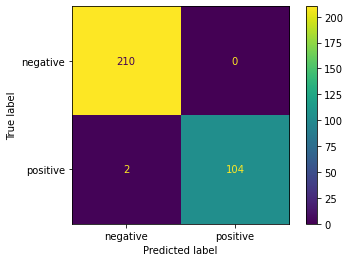

In [40]:
ConfusionMatrixDisplay.from_predictions(y_train, y_train_bow_predict)

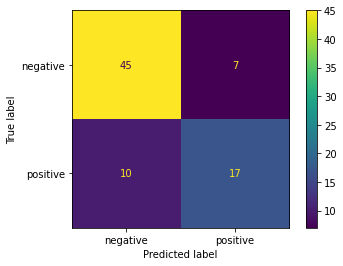

In [41]:
ConfusionMatrixDisplay.from_predictions(y_test, y_test_bow_predict)

In [42]:
# Metrics calculation for binary classes
print('Precision:', precision_score(y_test, y_test_bow_predict, pos_label = 'positive'))
print('Recall:', recall_score(y_test, y_test_bow_predict, pos_label = 'positive'))
print('F1:', f1_score(y_test, y_test_bow_predict, pos_label = 'positive'))

Precision: 0.7083333333333334
Recall: 0.6296296296296297
F1: 0.6666666666666667


In [43]:
# Metrics calculation for more than two classes
print('Precision:', precision_score(y_test, y_test_bow_predict, average = None))
print('Recall:', recall_score(y_test, y_test_bow_predict, average = None))
print('F1:', f1_score(y_test, y_test_bow_predict, average = None))

Precision: [0.81818182 0.70833333]
Recall: [0.86538462 0.62962963]
F1: [0.8411215  0.66666667]


### Training and evaluating a model using TF-IDF

In [44]:
model = RandomForestClassifier()

In [45]:
model.fit(X_tfidf, y_train)

RandomForestClassifier()

In [46]:
y_train_tfidf_predict = model.predict(X_tfidf)
y_test_tfidf_predict = model.predict(bow.transform(X_test))

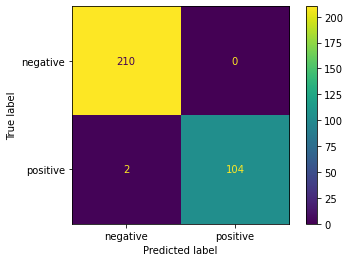

In [47]:
ConfusionMatrixDisplay.from_predictions(y_train, y_train_tfidf_predict)

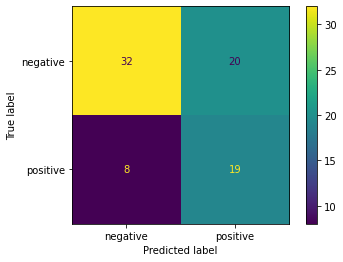

In [48]:
ConfusionMatrixDisplay.from_predictions(y_test, y_test_tfidf_predict)

In [49]:
# Metrics calculation for binary classes
print('Precision:', precision_score(y_test, y_test_tfidf_predict, pos_label = 'positive'))
print('Recall:', recall_score(y_test, y_test_tfidf_predict, pos_label = 'positive'))
print('F1:', f1_score(y_test, y_test_tfidf_predict, pos_label = 'positive'))

Precision: 0.48717948717948717
Recall: 0.7037037037037037
F1: 0.5757575757575758


In [50]:
# Metrics calculation for more than two classes
print('Precision:', precision_score(y_test, y_test_tfidf_predict, average = None))
print('Recall:', recall_score(y_test, y_test_tfidf_predict, average = None))
print('F1:', f1_score(y_test, y_test_tfidf_predict, average = None))

Precision: [0.8        0.48717949]
Recall: [0.61538462 0.7037037 ]
F1: [0.69565217 0.57575758]


### How interpret the results?

<table>
    <tbody>
        <tr>
            <td>
                <img src="./imgs/confusion-matrix.png" style="height: 400px;">
            </td>
            <td>
                <img src="./imgs/precision-recall.png" style="height: 600px;">
            </td>
        </tr>
    </tbody>
</table>

### Analyzing errors

In [51]:
error_df = pd.concat(
    [ pd.concat([X_test, y_test ], axis = 1).reset_index(),
    pd.Series(y_test_bow_predict) ]
, axis = 1).rename(columns = { 'sentiment': 'actual', 0: 'predicted' })

error_df.drop('index', inplace = True, axis = 1)

In [52]:
error_df.shape

(79, 3)

In [54]:
len(error_df.loc[error_df['actual'] != error_df['predicted']].head(100))

17